## Initialization

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from PIL import Image
import glob, os
import matplotlib.pyplot as plt

In [2]:
def load_data(file_name, parse_dates=None, dtype=None, sep=','):
    df=''
    
    try:
        df=pd.read_csv('datasets/faces/{}'.format(file_name), parse_dates=parse_dates, dtype=dtype, sep=sep)
    except:
        df=pd.read_csv('/datasets/faces/{}'.format(file_name), parse_dates=parse_dates, dtype=dtype, sep=sep)
        
    return df

In [3]:
df=load_data('labels.csv')
df.head(2)

,Unnamed: 0,file_name,real_age
0,0,000000.jpg,4
1,1,000001.jpg,18


Load some sample images.

In [4]:
base_dir=r'D:\\OneDrive\\Backup\\AI Course\\Projects\\DS\\09 Computer Vision'

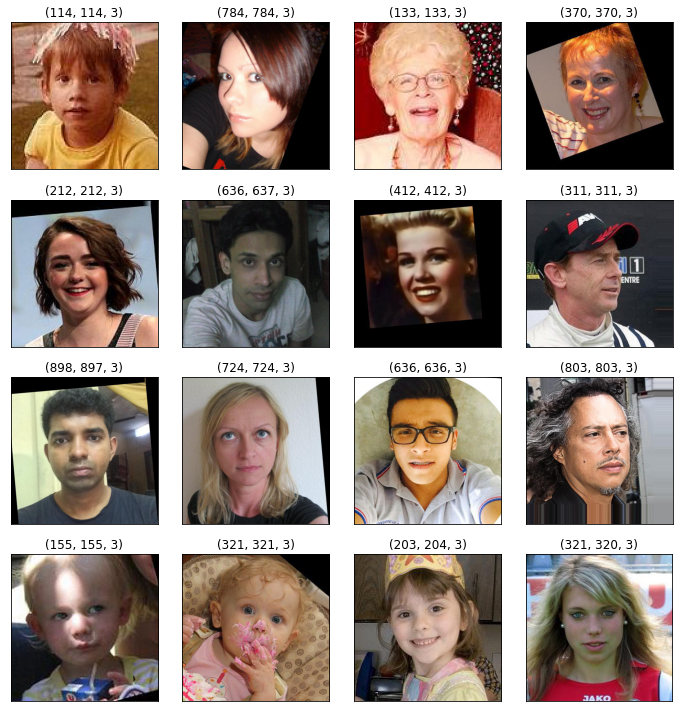

In [79]:
fig = plt.figure(figsize=(10,10))
num=0
for infile in glob.glob(base_dir+"/datasets/faces/final_files/*.jpg"):
    file, ext = os.path.splitext(infile)
    with Image.open(infile) as im:
        fig.add_subplot(4, 4, num+1)
        image = Image.open(file+ ".jpg")
        img_arr=np.array(image)
        plt.imshow(img_arr);
        plt.title(img_arr.shape)
        # remove axes and place the images closer to one another for a more compact output
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    num+=1
    if num==16:
        break

Each image has a different resolution, the default working size for the ImageDataGenerator is (256, 256), and that size will be used.

## EDA

Some statistical data on the age representation in the faces dataset.

In [5]:
df.real_age.describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Most of the samples are of young poeple, 75% of all samples are up to the age of 41.

This is how age is distributed through the faces dataset.

In [7]:
fig = px.histogram(
    df, x="real_age", nbins=20, labels={'real_age':'Real Age'},
    title="Age distribution in faces dataset"
)
fig.show()

The age distribution is right skewed. Meaning that most of the samples are of a young people.

Finding the decade of which each age is belong to.

In [10]:
df['decade']=(df.real_age/10).astype(int)+1
df.head()

,Unnamed: 0,file_name,real_age,decade
0,0,000000.jpg,4,1
1,1,000001.jpg,18,2
2,2,000002.jpg,80,9
3,3,000003.jpg,50,6
4,4,000004.jpg,17,2


Grouping ages by decade

In [11]:
df_grouped_by_decade=df[['decade', 'real_age']].groupby('decade').count().reset_index()
fig = px.pie(df_grouped_by_decade, values='real_age', names='decade', title='Ages by decade')
fig.show()

In [12]:
fig = px.bar(df_grouped_by_decade, y='real_age', x='decade', color='decade', 
             title='Ages by decade', labels={'real_age':'Real Age', 'decade':'Decade'})
fig.show()

### Findings

The samples are ranging from a 1 year old till the age of 100, but most of the samples are of young poeple, 75% of all samples are up to the age of 41.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [60]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [61]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1011741063650939615
 xla_global_id: -1]

In [63]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """

    csv_path=path+'labels.csv'
    labels = pd.read_csv(csv_path)
    
    train_datagen = ImageDataGenerator(
        validation_split=0.25, rescale=1.0 / 255, 
         horizontal_flip=True, vertical_flip=True
    )
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels, directory=path + 'final_files/', x_col='file_name',
        y_col='real_age', target_size=(224, 224), batch_size=16,
        class_mode='raw', subset='training', seed=12345
    )
    
    return train_gen_flow

In [64]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    csv_path=path+'labels.csv'
    labels = pd.read_csv(csv_path)
    
    validation_datagen = ImageDataGenerator(
        validation_split=0.25, rescale=1.0 / 255
    )
    
    test_gen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels, directory=path + 'final_files/', x_col='file_name',
        y_col='real_age', target_size=(224, 224), batch_size=16,
        class_mode='raw', subset='validation', seed=12345
    )
    
    return test_gen_flow

In [65]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(
        input_shape=(224, 224, 3), weights='imagenet', include_top=False
    )
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    model.compile(
        loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=['mae']
    )

    return model

In [66]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True,
    )

    return model

A tester for the code above

In [ ]:
%%time
from datetime import datetime

print("Current Time =", datetime.now().strftime("%H:%M:%S"))

features_train=load_train(base_dir+'/datasets/faces/')
features_test=load_test(base_dir+'/datasets/faces/')


model = create_model(input_shape=(224, 224, 3))

model.summary()

model = train_model(model,
    features_train,
    features_test,
    batch_size=16,
    epochs=4,
    steps_per_epoch=None,
    validation_steps=None)

Current Time = 23:15:31
Found 5694 validated image filenames.
Found 1897 validated image filenames.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/4


### Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

Get the MAE score for the test set no higher than 8.

In [59]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

Train for 178 steps, validate for 60 steps

Epoch 1/10

2022-05-10 20:04:45.550413: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2022-05-10 20:04:45.841065: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

178/178 - 48s - loss: 255.4933 - mae: 11.6220 - val_loss: 1113.1806 - val_mae: 28.8556

Epoch 2/10

178/178 - 40s - loss: 101.7300 - mae: 7.6564 - val_loss: 593.9275 - val_mae: 19.2589

Epoch 3/10

178/178 - 40s - loss: 78.1305 - mae: 6.6794 - val_loss: 266.3893 - val_mae: 12.4814

Epoch 4/10

178/178 - 39s - loss: 69.2099 - mae: 6.2798 - val_loss: 183.4507 - val_mae: 9.9774

Epoch 5/10

178/178 - 39s - loss: 52.6020 - mae: 5.5035 - val_loss: 88.4409 - val_mae: 7.1775

Epoch 6/10

178/178 - 39s - loss: 44.0503 - mae: 5.0400 - val_loss: 80.1887 - val_mae: 6.7460

Epoch 7/10

178/178 - 39s - loss: 39.3194 - mae: 4.7702 - val_loss: 82.3378 - val_mae: 7.0059

Epoch 8/10

Epoch 9/10

178/178 - 39s - loss: 32.0275 - mae: 4.3155 - val_loss: 70.2617 - val_mae: 6.1783

178/178 - 39s - loss: 29.9346 - mae: 4.1513 - val_loss: 69.8234 - val_mae: 6.3186

Epoch 10/10

178/178 - 39s - loss: 27.7447 - mae: 3.9992 - val_loss: 71.9320 - val_mae: 6.3063

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

60/60 - 10s - loss: 71.9320 - mae: 6.3063

Test MAE: 6.3063


## Conclusions

Even though neural networks require a lot of computing power in the training phase, they have very good results. This case study demonstrates how it manages to verify the age of the buyer without causing the client any hassle and saving the seller time, although the results of MAE of 6.3 suggests that the model can be wrong by about 6 years, so for example if a model predicts 22, a person can easily be 16.

# Checklist

- [ ]  Notebook was opened
- [ ]  The code is error free
- [ ]  The cells with code have been arranged by order of execution
- [ ]  The exploratory data analysis has been performed
- [ ]  The results of the exploratory data analysis are presented in the final notebook
- [ ]  The model's MAE score is not higher than 8
- [ ]  The model training code has been copied to the final notebook
- [ ]  The model training output has been copied to the final notebook
- [ ]  The findings have been provided based on the results of the model training